# Notebook 4: Feature Engineering

In [2]:
import json
import random
import copy
import os
import string
import pandas as pd
from difflib import SequenceMatcher
import matplotlib.pyplot as plt
import seaborn as sns

PAIRS_PATH = os.path.join('..', 'data', 'processed', 'pairs') 
MANUAL_PAIRS_FILE = os.path.join(PAIRS_PATH, 'manual_pairs.json')
AUTO_PAIRS_FILE = os.path.join(PAIRS_PATH, 'auto_pairs.json')

PROCESSED_PATH = os.path.join('..', 'data', 'processed', 'modelling')

## 1. Load Data

In [3]:
def load_pairs(filepath):
    if not os.path.exists(filepath):
        print(f"Error: File not found {filepath}")
        return {}
    
    with open(filepath, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    return data


In [4]:
print("Loading Pair Datasets...")
manual_grouped = load_pairs(MANUAL_PAIRS_FILE)
auto_grouped = load_pairs(AUTO_PAIRS_FILE)

print(f"Loaded Manual Papers: {len(manual_grouped)}")
print(f"Loaded Auto Papers:   {len(auto_grouped)}")

Loading Pair Datasets...
Loaded Manual Papers: 5
Loaded Auto Papers:   222


## 2. Create Datasets

In [5]:
def split_dataset_ids(all_ids, is_manual=False):
    all_ids.sort()
    random.seed(42) 
    random.shuffle(all_ids)
    
    if is_manual:
        if len(all_ids) < 2:
            print("Warning: Not enough manual papers. Using all for Train.")
            return all_ids, [], []
            
        test_ids = [all_ids[0]]
        val_ids = [all_ids[1]]
        train_ids = all_ids[2:]
    else:
        # Split: 70% Train, 15% Val, 15% Test
        n = len(all_ids)
        n_test = int(n * 0.15)
        n_val = int(n * 0.15)
        
        test_ids = all_ids[:n_test]
        val_ids = all_ids[n_test : n_test + n_val]
        train_ids = all_ids[n_test + n_val :]
        
    return train_ids, val_ids, test_ids

def flatten_dataset(grouped_data, selected_ids):
    flat_data = []
    for pid in selected_ids:
        if pid in grouped_data:
            flat_data.extend(grouped_data[pid])
    return flat_data

In [6]:
man_ids = list(manual_grouped.keys())
auto_ids = list(auto_grouped.keys())

man_train, man_val, man_test = split_dataset_ids(man_ids, is_manual=True)
auto_train, auto_val, auto_test = split_dataset_ids(auto_ids, is_manual=False)

print("\n--- Split Statistics (Paper Counts) ---")
print(f"Manual: Train={len(man_train)}, Val={len(man_val)}, Test={len(man_test)}")
print(f"Auto:   Train={len(auto_train)}, Val={len(auto_val)}, Test={len(auto_test)}")

train_set = flatten_dataset(manual_grouped, man_train) + flatten_dataset(auto_grouped, auto_train)
val_set   = flatten_dataset(manual_grouped, man_val)   + flatten_dataset(auto_grouped, auto_val)
test_set  = flatten_dataset(manual_grouped, man_test)  + flatten_dataset(auto_grouped, auto_test)

print("\n--- Final Pair Counts ---")
print(f"Training Pairs:   {len(train_set)}")
print(f"Validation Pairs: {len(val_set)}")
print(f"Test Pairs:       {len(test_set)}")


--- Split Statistics (Paper Counts) ---
Manual: Train=3, Val=1, Test=1
Auto:   Train=156, Val=33, Test=33

--- Final Pair Counts ---
Training Pairs:   19215
Validation Pairs: 2180
Test Pairs:       5694


## 3. Data Augmentation

In [7]:
def augment_delete_word(text):
    words = text.split()
    if len(words) < 2: return text
    idx = random.randint(0, len(words) - 1)
    words.pop(idx)
    
    return " ".join(words)

def augment_swap_chars(text):
    if len(text) < 2: return text
    chars = list(text)
    for _ in range(5):
        idx = random.randint(0, len(chars) - 2)
        if chars[idx] == ' ' or chars[idx+1] == ' ': continue
        chars[idx], chars[idx+1] = chars[idx+1], chars[idx]
        return "".join(chars)
    
    return text

def augment_delete_char(text):
    if len(text) < 2: return text
    idx = random.randint(0, len(text) - 1)

    return text[:idx] + text[idx+1:]

def augment_truncate(text):
    words = text.split()
    if len(words) <= 3: return text
    
    cut_point = random.randint(int(len(words)*0.3), int(len(words)*0.7))
    
    cut_point = max(3, cut_point)

    return " ".join(words[:cut_point])

def augment_heavy_deletion(text):
    words = text.split()
    if len(words) <= 3: 
        return text
    
    num_to_keep = int(len(words) * 0.6)

    return " ".join(random.sample(words, max(2, num_to_keep)))

def generate_augmented_data(pairs_list, augmentation_ratio=1.0):
    augmented_pairs = []
    
    aug_funcs = [
        augment_delete_word, 
        augment_swap_chars, 
        augment_delete_char,
        augment_truncate,       
        augment_heavy_deletion  
    ]
    
    for pair in pairs_list:
        augmented_pairs.append(pair)
        
        if pair['label'] == 1:
            for _ in range(int(augmentation_ratio)):
                new_pair = copy.deepcopy(pair)
                original_title = new_pair['source']['clean_title']
                
                func = random.choice(aug_funcs)
                noisy_title = func(original_title)
                
                if random.random() < 0.2:
                    func2 = random.choice(aug_funcs)
                    noisy_title = func2(noisy_title)

                new_pair['source']['clean_title'] = noisy_title
                new_pair['is_augmented'] = True
                augmented_pairs.append(new_pair)
                
    return augmented_pairs

In [8]:
print(f"Original Training Size: {len(train_set)}")

train_set_augmented = generate_augmented_data(train_set, augmentation_ratio=1.0)

print(f"Augmented Training Size: {len(train_set_augmented)}")

positive_samples = [p for p in train_set_augmented if p.get('is_augmented')]
if positive_samples:
    print("\n--- Augmentation Example ---")
    sample = positive_samples[0]
    print(f"Original Candidate: {sample['candidate']['clean_title']}")
    print(f"Noisy Source:       {sample['source']['clean_title']}")

Original Training Size: 19215
Augmented Training Size: 22444

--- Augmentation Example ---
Original Candidate: annotation efficient deep learning automatic medical image segmentation
Noisy Source:       learning annotation image medical


## 4. Create Features

In [9]:
def calc_levenshtein_ratio(s1, s2):
    if not s1 or not s2: 
        return 0.0
    
    return SequenceMatcher(None, s1, s2).ratio()

def calc_jaccard_sim(set1, set2):
    if not set1 or not set2: 
        return 0.0

    s1 = set(set1) if isinstance(set1, list) else set1
    s2 = set(set2) if isinstance(set2, list) else set2
    
    if len(s1) == 0 or len(s2) == 0: return 0.0
    
    intersection = len(s1.intersection(s2))
    union = len(s1.union(s2))
    return intersection / union

def calc_year_diff(year1, year2):
    try:
        year1_int = int(str(year1).strip())
        year2_int = int(str(year2).strip())
        diff = abs(year1_int - year2_int)
        
        return min(diff, 50)
    except (ValueError, TypeError):
        return 10

def create_features_dataframe(pairs_list):
    features = []
    labels = []
    
    for row in pairs_list:
        src = row['source']
        cand = row['candidate']
        
        # 1. Title Features
        t1 = src.get('clean_title', '')
        t2 = cand.get('clean_title', '')
        
        title_lev = calc_levenshtein_ratio(t1, t2)
        
        # Jaccard on title words
        t1_tokens = set(t1.split())
        t2_tokens = set(t2.split())
        title_jaccard = calc_jaccard_sim(t1_tokens, t2_tokens)
        
        # 2. Author Features
        a1 = src.get('clean_author_tokens', [])
        a2 = cand.get('clean_author_tokens', [])
        auth_jaccard = calc_jaccard_sim(a1, a2)
        
        # Common Author Count
        auth_overlap = len(set(a1).intersection(set(a2))) if a1 and a2 else 0
        
        # 3. Year Features
        y1 = src.get('year', '')
        y2 = cand.get('year', '')
        year_diff = calc_year_diff(y1, y2)
        
        features.append({
            'title_levenshtein': title_lev,
            'title_jaccard': title_jaccard,
            'author_jaccard': auth_jaccard,
            'author_overlap_count': auth_overlap,
            'year_diff': year_diff
        })
        
        labels.append(row['label'])
        
    return pd.DataFrame(features), pd.Series(labels)

In [10]:
print("Calculating features for Training Set...")
X_train, y_train = create_features_dataframe(train_set_augmented)

print("Calculating features for Validation Set...")
X_val, y_val = create_features_dataframe(val_set)

print("Calculating features for Test Set...")
X_test, y_test = create_features_dataframe(test_set)

print("\n--- Feature Matrix Shape ---")
print(f"X_train: {X_train.shape}")
print(f"X_val:   {X_val.shape}")
print(f"X_test:  {X_test.shape}")

print("\nSample Data:")
print(X_train.head())

Calculating features for Training Set...
Calculating features for Validation Set...
Calculating features for Test Set...

--- Feature Matrix Shape ---
X_train: (22444, 5)
X_val:   (2180, 5)
X_test:  (5694, 5)

Sample Data:
   title_levenshtein  title_jaccard  author_jaccard  author_overlap_count  \
0           1.000000       1.000000        0.551724                    16   
1           0.423077       0.500000        0.551724                    16   
2           0.462963       0.181818        0.000000                     0   
3           0.232143       0.000000        0.000000                     0   
4           0.207650       0.043478        0.000000                     0   

   year_diff  
0          1  
1          1  
2          5  
3          3  
4          1  


## 5. Feature Analysis

----------------------------------------
EXPLORATORY DATA ANALYSIS (Justification for Features)
----------------------------------------

Mean Feature Values by Label (0=No Match, 1=Match):
       title_levenshtein  title_jaccard  author_jaccard  author_overlap_count  \
label                                                                           
0               0.330855       0.067985        0.021788              0.395784   
1               0.887911       0.818451        0.672700              7.650666   

       year_diff  
label             
0       3.946891  
1       0.807990  


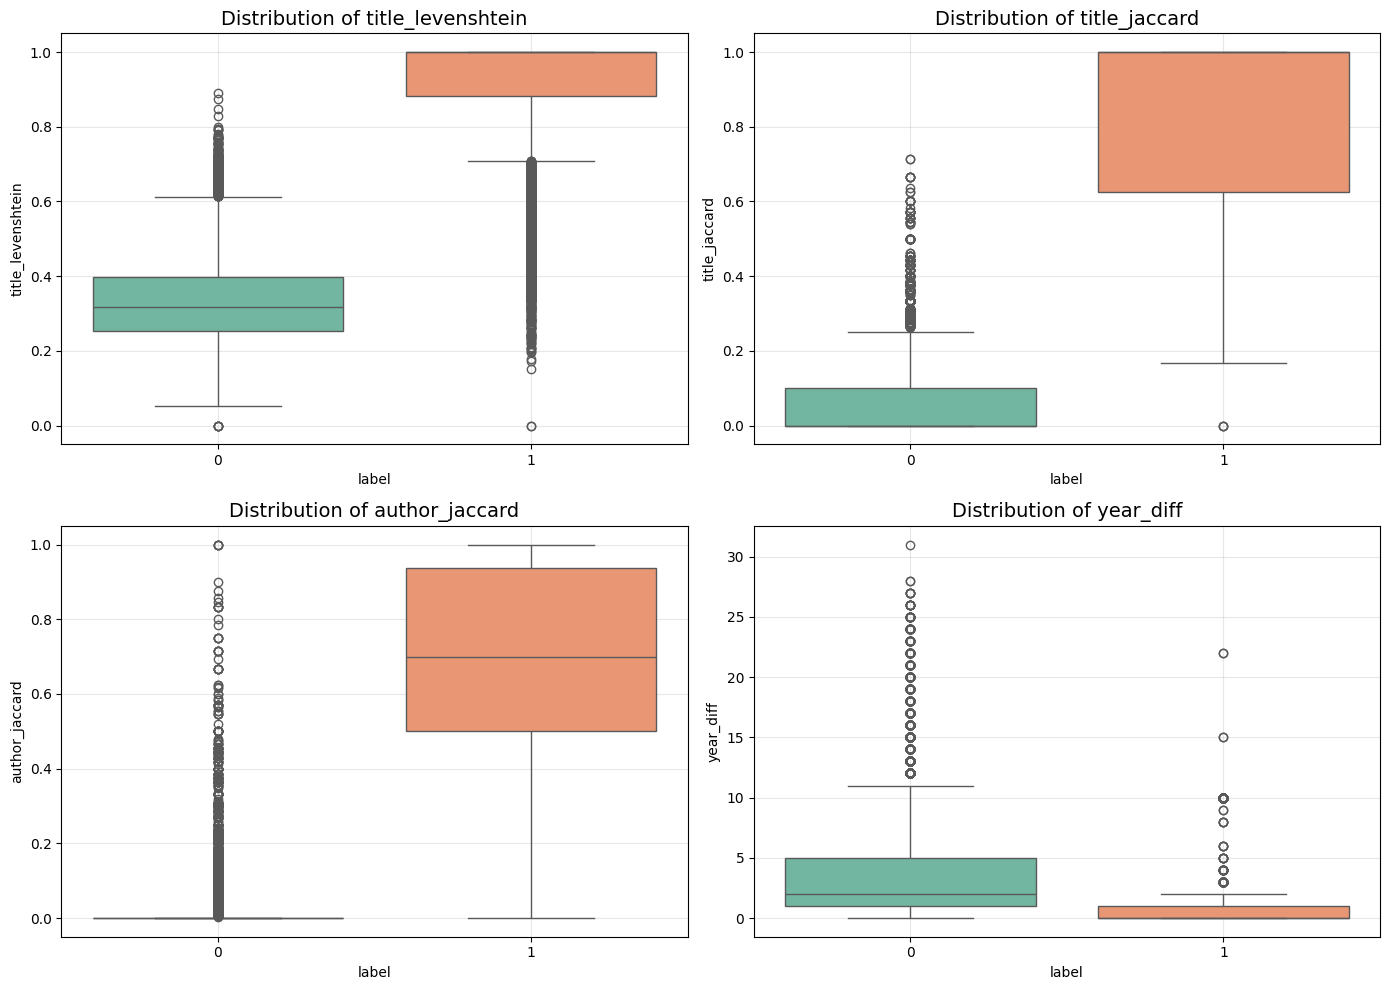

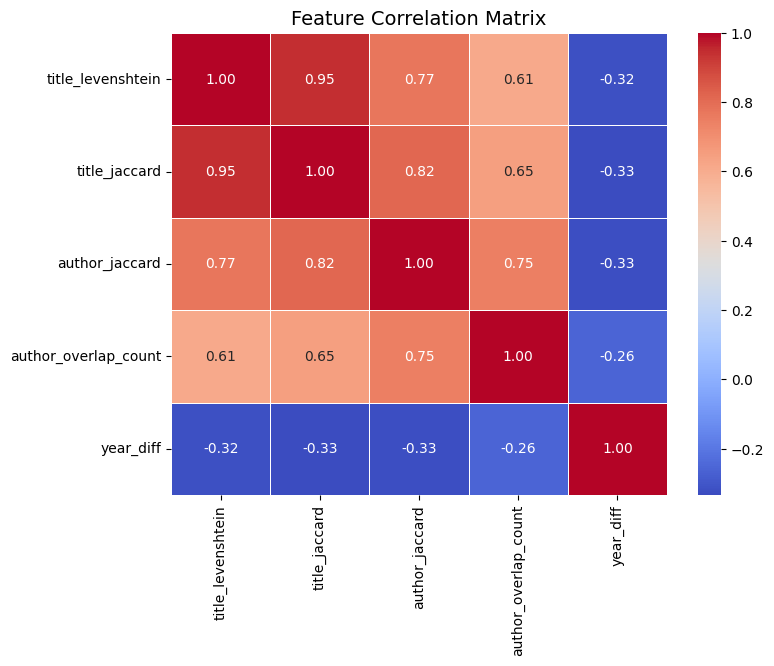

In [11]:
eda_df = X_train.copy()
eda_df['label'] = y_train

print("-" * 40)
print("EXPLORATORY DATA ANALYSIS (Justification for Features)")
print("-" * 40)

summary = eda_df.groupby('label').mean()
print("\nMean Feature Values by Label (0=No Match, 1=Match):")
print(summary)

features_to_plot = ['title_levenshtein', 'title_jaccard', 'author_jaccard', 'year_diff']

plt.figure(figsize=(14, 10))
for i, col in enumerate(features_to_plot):
    plt.subplot(2, 2, i+1)
    sns.boxplot(x='label', y=col, data=eda_df, palette="Set2", hue='label', legend=False)
    plt.title(f'Distribution of {col}', fontsize=14)
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
correlation_matrix = X_train.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Matrix", fontsize=14)
plt.show()

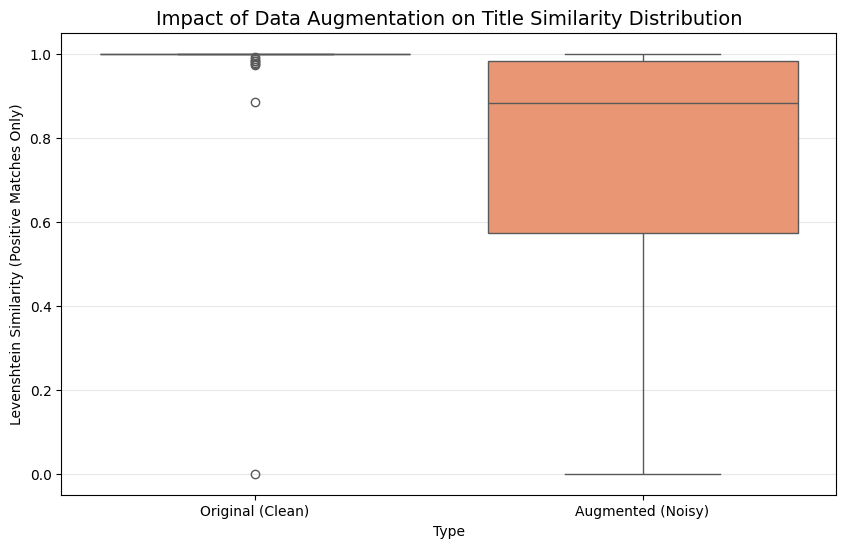

--- Distribution of Positive Matches ---
Original Median Similarity:  1.0000
Augmented Median Similarity: 0.8833
Augmented 25th Percentile:   0.5741


In [14]:
original_positives = [p for p in train_set_augmented if p['label'] == 1 and not p.get('is_augmented')]
augmented_positives = [p for p in train_set_augmented if p.get('is_augmented')]

df_orig, _ = create_features_dataframe(original_positives)
df_aug, _ = create_features_dataframe(augmented_positives)

df_orig['Type'] = 'Original (Clean)'
df_aug['Type'] = 'Augmented (Noisy)'

df_comparison = pd.concat([df_orig, df_aug])

plt.figure(figsize=(10, 6))
sns.boxplot(x='Type', y='title_levenshtein', data=df_comparison, palette='Set2', hue = 'Type', legend=False)
plt.title("Impact of Data Augmentation on Title Similarity Distribution", fontsize=14)
plt.ylabel("Levenshtein Similarity (Positive Matches Only)")
plt.grid(axis='y', alpha=0.3)
plt.show()

print("--- Distribution of Positive Matches ---")
print(f"Original Median Similarity:  {df_orig['title_levenshtein'].median():.4f}")
print(f"Augmented Median Similarity: {df_aug['title_levenshtein'].median():.4f}")
print(f"Augmented 25th Percentile:   {df_aug['title_levenshtein'].quantile(0.25):.4f}")

## 6. Save Datasets

In [13]:
def save_dataset(df, name):
    file_path = os.path.join(PROCESSED_PATH, f'{name}.csv')
    df.to_csv(file_path, index=False)
    print(f"  -> Saved {name}: {len(df)} rows")

save_dataset(X_train, 'X_train')
save_dataset(y_train, 'y_train')

save_dataset(X_val, 'X_val')
save_dataset(y_val, 'y_val')

save_dataset(X_test, 'X_test')
save_dataset(y_test, 'y_test')

  -> Saved X_train: 22444 rows
  -> Saved y_train: 22444 rows
  -> Saved X_val: 2180 rows
  -> Saved y_val: 2180 rows
  -> Saved X_test: 5694 rows
  -> Saved y_test: 5694 rows
